In [1]:
import torch as th
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from papersim.sim_modules import Module, Transition
from papersim.risk_generator import Risk, RiskGen

## Model parametrization

In [3]:
prod_matrix = th.tensor([[0, 0, 0],
                         [0, 0, 0],
                         [1, 1, 0]], dtype=th.int32)

mod_a = Module(0, 0, prod_matrix[0], 10)
mod_b = Module(1, 1, prod_matrix[1], 10)
mod_c = Module(2, 2, prod_matrix[2], 10)

tra_ac = Transition(3, 0, 2, 0, 10)
tra_bc = Transition(4, 1, 2, 1, 10)

sc = [mod_a, tra_ac, mod_b, tra_bc, mod_c]

risks = [Risk(1/365, 0.8, 10, [0, 1, 2, 3, 4]), # Software brakedown, once a year
         Risk(0.02, 0.1, 100, [1]), #
         Risk(0.02, 0.2, 5, [2, 3]),
         Risk(0.002, 0.9, 30, [0, 1, 4]),
         Risk(0.02, 0.3, 1, [2, 3]),
         Risk(0.1, 0.05, 10, [1, 2]),
         Risk(1 / 700, 1, 2, [0, 1], global_effect=True), # Wheater risk, once every 2 months
]

riskgen = RiskGen(risks, 5)

C:\Users\Silvan\PycharmProjects\BusinessRiskSim\papersim\risk_generator.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  self.module_assignment = th.tensor(module_assignment, dtype=th.int32)


## Run and plot

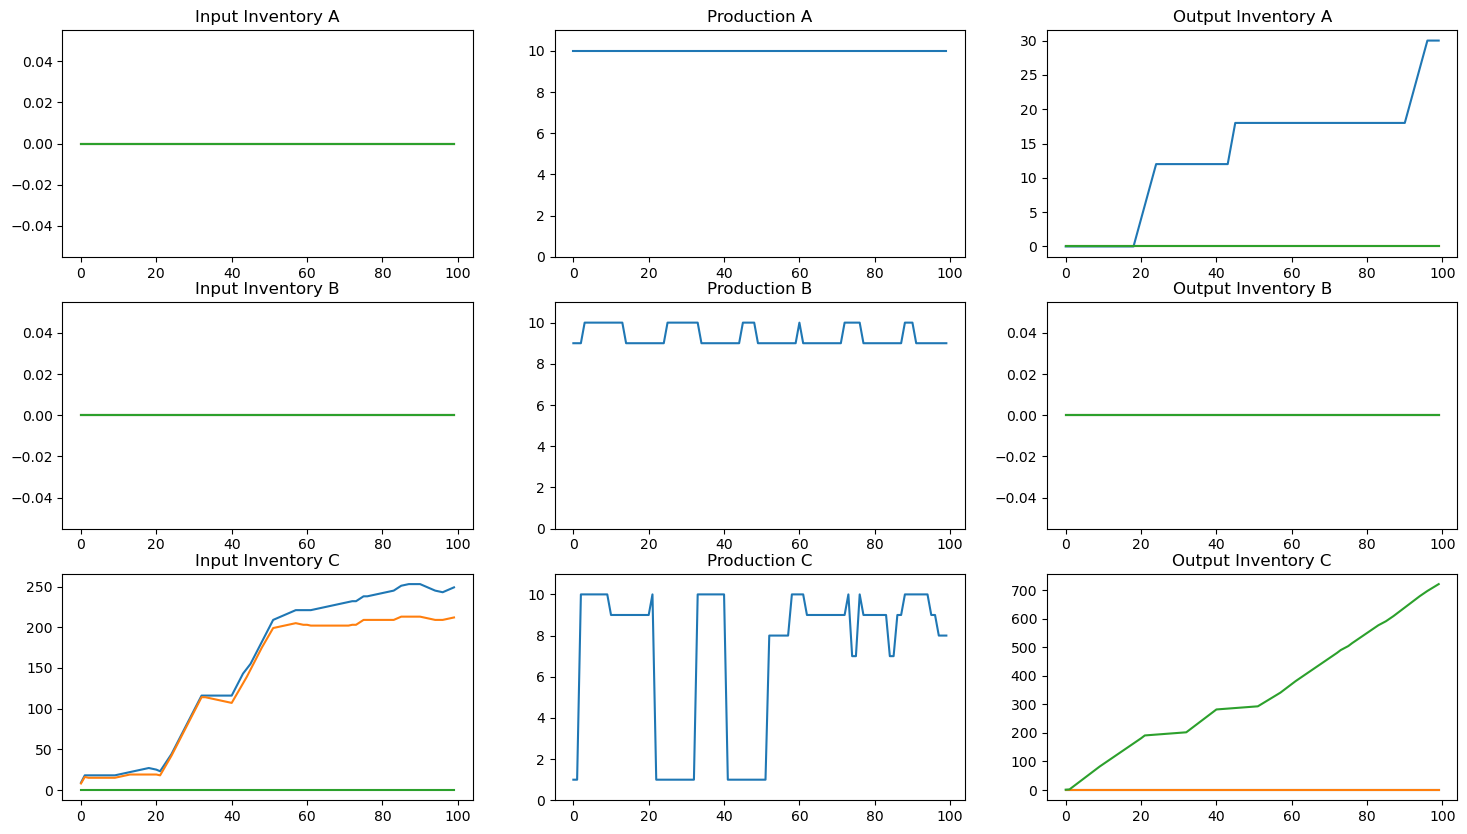

In [11]:
prod_tensor = th.zeros(2, 3, 3, dtype=th.int32)

t_run = 100

inventory = th.zeros(t_run, 2, 3, 3)
produced = th.zeros(t_run, 1, 3, 3)

for i in range(t_run):
    riskgen.step()

    # risks
    for mod in sc:
        if isinstance(mod, Module):
            mod.current_capacity = riskgen.get_cap_i(mod.mod_idx)
            prod_tensor, num_produced = mod.process(prod_tensor)
            produced[i, 0, mod.mod_idx, mod.prod_idx] = num_produced
        elif isinstance(mod, Transition):
            mod.current_capacity = riskgen.get_cap_i(mod.idx)
            prod_tensor = mod.process(prod_tensor)

    #print(produced[i])

    inventory[i] = prod_tensor


fig, axs = plt.subplots(3, 3, figsize=(18, 10))

label = ['A', 'B', 'C']

for i in range(3):
    axs[i, 0].plot(inventory[:, 0, i, 0], )
    axs[i, 0].plot(inventory[:, 0, i, 1])
    axs[i, 0].plot(inventory[:, 0, i, 2])
    axs[i, 0].set_title("Input Inventory " + label[i])
    axs[i, 1].plot(produced[:, 0, i, i])
    axs[i, 1].set_ylim([0,11])
    axs[i, 1].set_title("Production " + label[i])
    axs[i, 2].plot(inventory[:, 1, i, 0])
    axs[i, 2].plot(inventory[:, 1, i, 1])
    axs[i, 2].plot(inventory[:, 1, i, 2])
    axs[i, 2].set_title("Output Inventory " + label[i])


plt.show()